Hemos seleccionado como dataset de pruebas el CBIS-DDSM, (Subconjunto curado de imágenes mamarias de DDSM), que incluye imágenes descomprimidas, seleccionadas y curadas de mamografías. El CBIS-DDSM (Subconjunto curado de imágenes mamarias de DDSM) es una versión actualizada y estandarizada de la base de datos digital para mamografías de detección (DDSM). El DDSM es una base de datos de 2620 estudios de mamografía de película escaneada. Contiene casos normales, benignos y malignos con información patológica verificada. El conjunto de datos proporciona un tamaño de conjunto de datos capaz de analizar los sistemas de apoyo a la toma de decisiones en mamografía.
Otros de los motivos que nos han ayudado a seleccionar este conjunto de datos como veremos mas adelante es que ya vienen etiquetados los subconjuntos de entrenamiento y test balanceados correctamente en función de la dificultad del diagnóstico

Para la descarga vamos a hacer uso de la API de Kaagle, para poder reutilizar este notebook es necesario estar dado de alto en Kaagle y poder descargarse un token.

### **Imports**

In [1]:
! pip install -q kaggle

In [2]:
#from google.colab import files
#from google.colab import drive
#from glob import glob


# comunes
import os
import keras
import numpy as np
import pandas as pd
import random
import cv2
import tensorflow as tf
import tensorflow.image as tfi

from tqdm import tqdm
from mpl_toolkits.axes_grid1 import ImageGrid

# Data
from tensorflow.keras.utils import load_img,img_to_array
#from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

### **Funciones y constantes**

In [3]:
#PATH = 'aryashah2k/breast-ultrasound-images-dataset'
PATH = 'awsaf49/cbis-ddsm-breast-cancer-image-dataset'
SIZE = 256

In [4]:
def show_study(fila, df):
  img_full = cv2.imread(df.loc[fila, 'full_image_path'],0)
  img_cropped = cv2.imread(df.loc[fila, 'cropped_image_path'],0)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.suptitle(df.loc[fila, 'pathology'])
  ax1.imshow(img_full)
  ax1.set_title('Full image')
  ax2.imshow(img_cropped)
  ax2.set_title('Cropped image')


def show_img(path):
    img = cv2.imread(path,0)
    plt.figure(figsize=(10,10))
    plt.imshow(img,cmap='bone')

def show_grid(files, row=3, col=3):
    grid_files = random.sample(files, row*col)
    images     = []
    for image_path in tqdm(grid_files):
        img          = cv2.resize(cv2.imread(image_path), dsize=(512,512))
        images.append(img)

    fig = plt.figure(figsize=(col*5, row*5))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(col, row),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

#Deprecadas
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)


def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

### **Carga de datos**

Es necesario desde tu cuenta de Kaggle, ir a la opción API y darle a la opción **Create New API token** que nos descargará un fichero .json que seleccionaremos en el siguiente apartado.

In [5]:
#files.upload()

Creamos una carpeta oculta en nuestro entorno de trabajo donde copiamos el fichero recien subido con nuestras credenciales

In [6]:
#! mkdir  ~/.kaggle

Copiamos el fichero y le damos permiso de lectura

In [7]:
#! cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json


Probamos si podemos invocar la API de Kaggle

In [8]:
#! kaggle datasets list

Descargamos nuestro dataset.

In [9]:
#!kaggle datasets download -d awsaf49/cbis-ddsm-breast-cancer-image-dataset

In [10]:
#Descomprimimos el fichero descargado
#!unzip /content/cbis-ddsm-breast-cancer-image-dataset.zip -d /content/cbis-ddsm

Activamos la unidad de drive para usarla en Colab y no tener que efectuar todos los pasos anteriores de descarga y descompresión cada vez

In [11]:
#drive.mount('/content/drive/')

Creamos directorio esn el drive donde descargaremos el dataset, estos pasos solo los debemos hacer la primera vez, asi que los dejo comentado

In [12]:
#!mkdir '/content/drive/My Drive/Colab Notebooks/db/cbis-ddsm'

In [13]:
#!unzip /content/cbis-ddsm-breast-cancer-image-dataset.zip -d '/content/drive/My Drive/Colab Notebooks/db/cbis-ddsm'

### Inspeccionamos los metadatos

El fichero que contiene la descripción básica de todas las imágenes es  **dicom_info.csv**.

In [14]:
#dataset_dir = '/content/drive/My Drive/Colab Notebooks/db/cbis-ddsm'
dataset_dir = '/home/fjcorrales/Master Ciencia de datos/TFM/dataset/archive'


df = pd.read_csv(f'{dataset_dir}/csv/dicom_info.csv')
df['image_path'] = df.image_path.apply(lambda x: x.replace('CBIS-DDSM', dataset_dir))
df.head()



,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


Nos interesan principalmente de este fichero la ubicación del fichero **image_path** , el tipo de imagen **SeriesDescription**, que puede ser *cropped images* o *full mammogram images*, la columna **PatientID** que nos dice si la imagen corresponde a una *masa* o  una *calcificación*, y **SeriesInstanceUID** que utlizaremos como identificador de cada imagen.


In [15]:
df[['image_path','SeriesDescription','PatientID','SeriesInstanceUID']].head()

,image_path,SeriesDescription,PatientID,SeriesInstanceUID
0,/home/fjcorrales/Master Ciencia de datos/TFM/d...,cropped images,Mass-Training_P_01265_RIGHT_MLO_1,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...
1,/home/fjcorrales/Master Ciencia de datos/TFM/d...,full mammogram images,Mass-Training_P_01754_RIGHT_CC,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...
2,/home/fjcorrales/Master Ciencia de datos/TFM/d...,full mammogram images,Calc-Training_P_00232_RIGHT_CC,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...
3,/home/fjcorrales/Master Ciencia de datos/TFM/d...,cropped images,Calc-Test_P_00562_LEFT_CC_2,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...
4,/home/fjcorrales/Master Ciencia de datos/TFM/d...,NaN,P_00562_LEFT_CC_2.dcm,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...


Miramos cuales son los diferentes tipos de imagenes que tenemos.

In [16]:
print(df.SeriesDescription.unique())

['cropped images' 'full mammogram images' nan 'ROI mask images']


Observamos que tenemos valores nulos en ese campo.

100%|██████████| 12/12 [00:00<00:00, 210.44it/s]


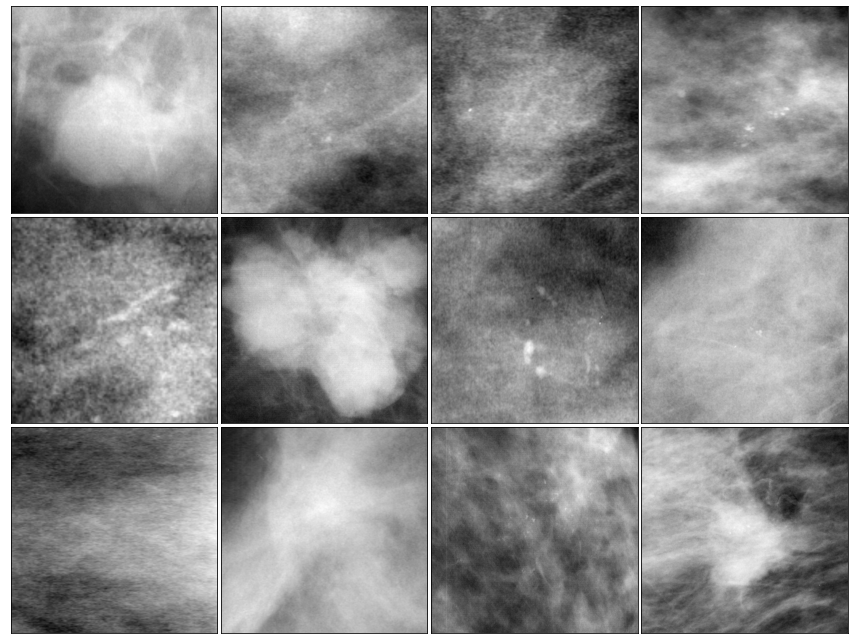

In [17]:
show_grid(df[df.SeriesDescription=='cropped images'].image_path.tolist(), row=4)

100%|██████████| 12/12 [00:01<00:00,  8.03it/s]


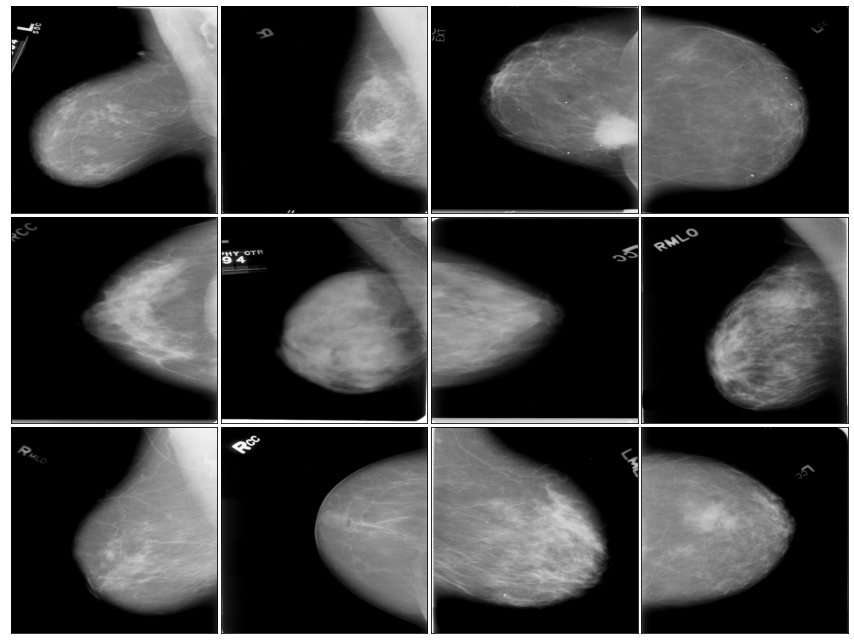

In [18]:
show_grid(df[df.SeriesDescription=='full mammogram images'].image_path.tolist(), row=4)

100%|██████████| 12/12 [00:01<00:00, 10.73it/s]


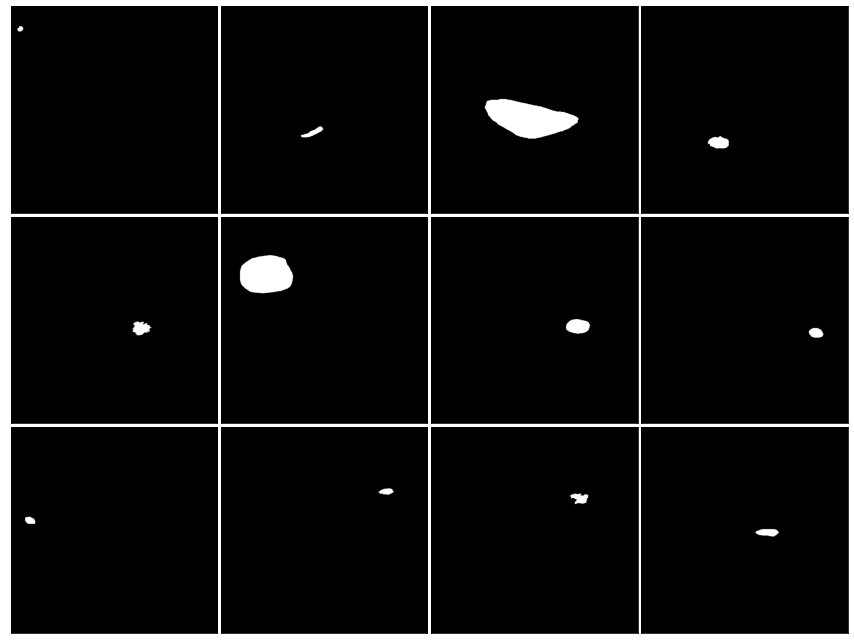

In [19]:
show_grid(df[df.SeriesDescription=='ROI mask images'].image_path.tolist(), row=4)

100%|██████████| 12/12 [00:01<00:00, 10.76it/s]


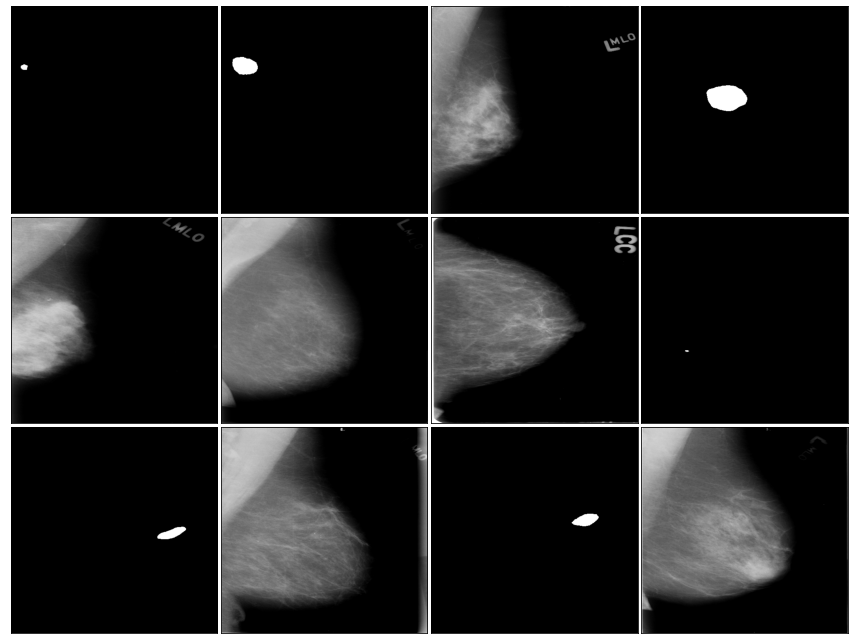

In [20]:
show_grid(df[df.SeriesDescription.isna()].image_path.tolist(), row=4)

In [21]:
df.loc[df['SeriesDescription'].isna(), 'SeriesDescription'] = 'Nulo'

Observamos cual es tamaño de cada serie

<AxesSubplot:>

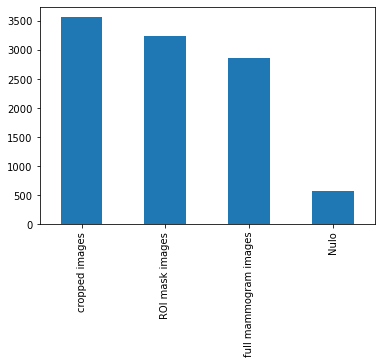

In [22]:

df['SeriesDescription'].value_counts().plot(kind='bar')


Para nuestro caso, solo nos interesan las imagenes de tipo **cropped** y **full mammogram images**, asi que eliminamos las filas que no sean de este tipo

<AxesSubplot:>

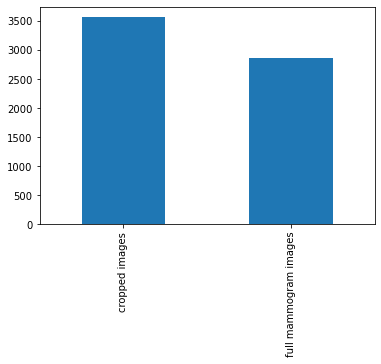

In [23]:
df = df.drop(df[df['SeriesDescription']=='Nulo'].index)
df = df.drop(df[df['SeriesDescription']=='ROI mask images'].index)
df['SeriesDescription'].value_counts().plot(kind='bar')


Otra propiedad que nos interesa es conocer el tamaño de las imagenes, y saber si todas tienen la misma resolución

In [24]:
print(df.Columns.unique())
print(df.Rows.unique())

[ 351 3526 1546 ... 1209  656 1297]
[ 289 6256 4126 ...  499 1281  772]


Existen dos tipos de anomalias detectadas, masas y calcificaciones. El objetivo es estudiarlas por separado y ver si el método aplicado se comporta igual en los dos subconjuntos.

#Preparamos el dataset de training de mass

In [25]:
#Leemos los metadatos de training de masas
df_mass_train = pd.read_csv(f'{dataset_dir}/csv/mass_case_description_train_set.csv')

#Renombramos columnas con espacios
df_mass_train = df_mass_train.rename(columns={'image file path':'image_file_path'})
df_mass_train = df_mass_train.rename(columns={'cropped image file path':'cropped_image_file_path'})
df_mass_train = df_mass_train.rename(columns={'ROI mask file path':'ROI_mask_file_path'})

#Preparamos las columnas por las que buscaremos en dicom_info el path de la imagen
df_mass_train['image_file_path_studyInstanceUID'] = df_mass_train.image_file_path.str.split("/",expand=True,)[1]
df_mass_train['cropped_image_file_path_studyInstanceUID'] = df_mass_train.cropped_image_file_path.str.split("/",expand=True,)[1]

#Creamos dos "sub"datasets para luego buscar segun el tipo de imagen que nos interese
full_images=df[df.SeriesDescription == 'full mammogram images']
cropped_images=df[df.SeriesDescription == 'cropped images']

#Hacemos join de los datasets para crear el path de la imagen en el dataset de training
df_mass_train['full_image_path']=pd.merge(df_mass_train, full_images, left_on='image_file_path_studyInstanceUID', right_on='StudyInstanceUID')['image_path']
df_mass_train['cropped_image_path']=pd.merge(df_mass_train, cropped_images, left_on='cropped_image_file_path_studyInstanceUID', right_on='StudyInstanceUID')['image_path']

df_mass_train.head()





,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path,image_file_path_studyInstanceUID,cropped_image_file_path_studyInstanceUID,full_image_path,cropped_image_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,1.3.6.1.4.1.9590.100.1.2.422112722213189649807...,1.3.6.1.4.1.9590.100.1.2.108268213011361124203...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,/home/fjcorrales/Master Ciencia de datos/TFM/d...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,1.3.6.1.4.1.9590.100.1.2.319478999311971442426...,1.3.6.1.4.1.9590.100.1.2.188473874511440575807...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,/home/fjcorrales/Master Ciencia de datos/TFM/d...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,1.3.6.1.4.1.9590.100.1.2.347107867812656628709...,1.3.6.1.4.1.9590.100.1.2.414182170112396175925...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,/home/fjcorrales/Master Ciencia de datos/TFM/d...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,1.3.6.1.4.1.9590.100.1.2.272600286511817402806...,1.3.6.1.4.1.9590.100.1.2.342549219112801262604...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,/home/fjcorrales/Master Ciencia de datos/TFM/d...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,1.3.6.1.4.1.9590.100.1.2.174047308712169195014...,1.3.6.1.4.1.9590.100.1.2.341142631111685501338...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,/home/fjcorrales/Master Ciencia de datos/TFM/d...


/home/fjcorrales/Master Ciencia de datos/TFM/dataset/archive/jpeg/1.3.6.1.4.1.9590.100.1.2.420516911812665689337358652421062172286/2-186.jpg


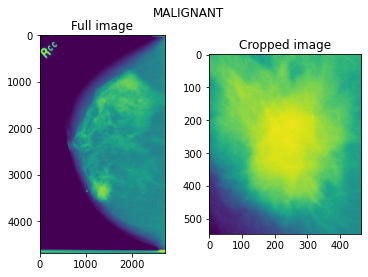

In [26]:
print(df_mass_train.loc[22, 'cropped_image_path'])
show_study(22,df_mass_train)

Comprobamos las diferentes etiquetas de clasificacion

<AxesSubplot:>

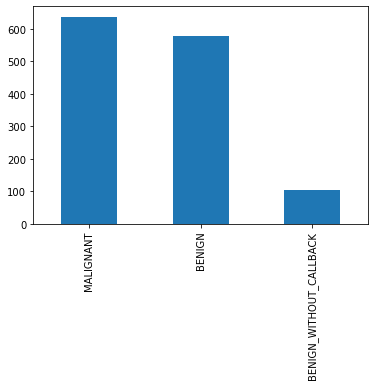

In [27]:
df_mass_train['pathology'].value_counts().plot(kind='bar')

Vamos a equipar la categoria BENIGN_WITHOUT_CALLBACK con BENIGN, para tener solo dos categorias.

<AxesSubplot:>

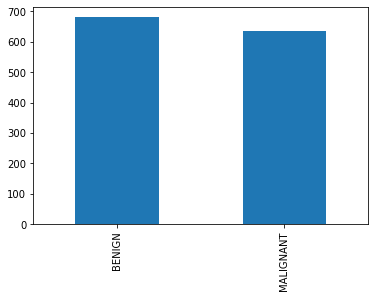

In [28]:
df_mass_train.loc[df_mass_train.pathology=='BENIGN_WITHOUT_CALLBACK','pathology']='BENIGN'
df_mass_train['pathology'].value_counts().plot(kind='bar')

Vamos a tratar el distinto tamaño de las imágenes.

<AxesSubplot:>

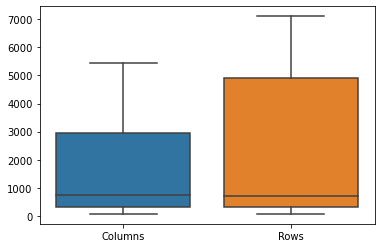

In [29]:
sns.boxplot(data=df[["Columns","Rows"]])

In [30]:
print("numero de columnas minimas", df.Columns.min())
print("numero de filas minimas", df.Rows.min())
columnas=68
filas=73

numero de columnas minimas 68
numero de filas minimas 73


Text(0.5, 1.0, 'Resized Cropped image')

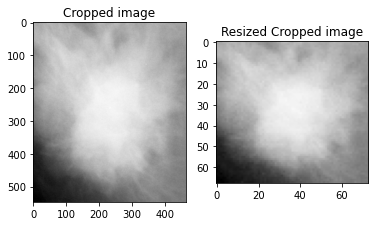

In [31]:
img_cropped = cv2.imread(df_mass_train.loc[22, 'cropped_image_path'],cv2.IMREAD_COLOR)
n_img_size = cv2.resize(img_cropped, (filas, columnas), interpolation = cv2.INTER_LINEAR)
  
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img_cropped)
ax1.set_title('Cropped image')
ax2.imshow(n_img_size)
ax2.set_title('Resized Cropped image')


Generamos los array de training redimensionando la imagen a los minimos encontrados

In [32]:
X_train_mass = []
y_train_mass = []

for i in range(len(df_mass_train)):
    img_cropped = cv2.imread(df_mass_train.loc[i, 'cropped_image_path'],cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(img_cropped, (filas, columnas), interpolation = cv2.INTER_LINEAR)
    X_train_mass.append(n_img_size)
    if df_mass_train.loc[i, 'pathology']=='BENIGN':
      y_train_mass.append(0)
    else:
      y_train_mass.append(1)
    
X_train_mass = np.array(X_train_mass)
y_train_mass = np.array(y_train_mass)


#Preparamos el dataset de test de mass

In [33]:
#Leemos los metadatos de training de masas
df_mass_test = pd.read_csv(f'{dataset_dir}/csv/mass_case_description_test_set.csv')

#Renombramos columnas con espacios
df_mass_test = df_mass_test.rename(columns={'image file path':'image_file_path'})
df_mass_test = df_mass_test.rename(columns={'cropped image file path':'cropped_image_file_path'})
df_mass_test = df_mass_test.rename(columns={'ROI mask file path':'ROI_mask_file_path'})

#Preparamos las columnas por las que buscaremos en dicom_info el path de la imagen
df_mass_test['image_file_path_studyInstanceUID'] = df_mass_test.image_file_path.str.split("/",expand=True,)[1]
df_mass_test['cropped_image_file_path_studyInstanceUID'] = df_mass_test.cropped_image_file_path.str.split("/",expand=True,)[1]

#Creamos dos "sub"datasets para luego buscar segun el tipo de imagen que nos interese
full_images=df[df.SeriesDescription == 'full mammogram images']
cropped_images=df[df.SeriesDescription == 'cropped images']

#Hacemos join de los datasets para crear el path de la imagen en el dataset de training
df_mass_test['full_image_path']=pd.merge(df_mass_test, full_images, left_on='image_file_path_studyInstanceUID', right_on='StudyInstanceUID')['image_path']
df_mass_test['cropped_image_path']=pd.merge(df_mass_test, cropped_images, left_on='cropped_image_file_path_studyInstanceUID', right_on='StudyInstanceUID')['image_path']

df_mass_test.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path,image_file_path_studyInstanceUID,cropped_image_file_path_studyInstanceUID,full_image_path,cropped_image_path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...,1.3.6.1.4.1.9590.100.1.2.416403281812750683720...,1.3.6.1.4.1.9590.100.1.2.259596319110047779433...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,/home/fjcorrales/Master Ciencia de datos/TFM/d...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....,1.3.6.1.4.1.9590.100.1.2.125010935311829990124...,1.3.6.1.4.1.9590.100.1.2.207144238612220754118...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,/home/fjcorrales/Master Ciencia de datos/TFM/d...
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...,1.3.6.1.4.1.9590.100.1.2.289610447411344525237...,1.3.6.1.4.1.9590.100.1.2.265130777712709757209...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,/home/fjcorrales/Master Ciencia de datos/TFM/d...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....,1.3.6.1.4.1.9590.100.1.2.223780641109314646327...,1.3.6.1.4.1.9590.100.1.2.668624952114641296207...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,/home/fjcorrales/Master Ciencia de datos/TFM/d...
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,Mass-Test_P_00032_RIGHT_CC/1.3.6.1.4.1.9590.10...,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....,1.3.6.1.4.1.9590.100.1.2.304236983211992984124...,1.3.6.1.4.1.9590.100.1.2.362221700813915332616...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,/home/fjcorrales/Master Ciencia de datos/TFM/d...


/home/fjcorrales/Master Ciencia de datos/TFM/dataset/archive/jpeg/1.3.6.1.4.1.9590.100.1.2.407181433912424288305829315861762316394/1-288.jpg


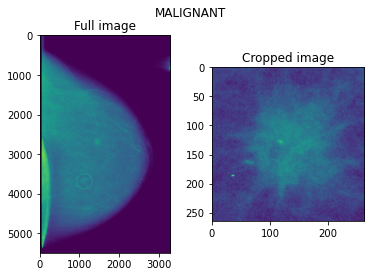

In [34]:
print(df_mass_test.loc[14, 'cropped_image_path'])
show_study(14,df_mass_train)

Generamos los array de test redimensionando la imagen a los minimos encontrados en el conjunto de training

In [35]:
X_test_mass = []
y_test_mass = []

for i in range(len(df_mass_test)):
    img_cropped = cv2.imread(df_mass_test.loc[i, 'cropped_image_path'],cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(img_cropped, (filas, columnas), interpolation = cv2.INTER_LINEAR)
    X_test_mass.append(n_img_size)

    if df_mass_test.loc[i, 'pathology']=='BENIGN':
      y_test_mass.append(0)
    else:
      y_test_mass.append(1)


X_test_mass = np.array(X_test_mass)
y_test_mass = np.array(y_test_mass)


y_train_mass = to_categorical(y_train_mass, 2)
y_test_mass = to_categorical(y_test_mass, 2)

print('X train shape : {}' .format(X_train_mass.shape))
print('y train shape : {}' .format(y_train_mass.shape))
print('X test shape : {}' .format(X_test_mass.shape))
print('y test shape : {}' .format(y_test_mass.shape))


X train shape : (1318, 68, 73, 3)
y train shape : (1318, 2)
X test shape : (378, 68, 73, 3)
y test shape : (378, 2)


In [36]:
#Normalizamos los datos
X_train_mass=X_train_mass/255
X_test_mass=X_test_mass/255

# **Preparación y entrenamiento de una red CNN**
Hacemos una prueba con una red CNN sencilla para comprobar un modelo "tradicional"

In [37]:
model = tf.keras.Sequential([
tf.keras.layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (columnas,filas,  3)),
tf.keras.layers.MaxPooling2D(strides = 2),
tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
tf.keras.layers.MaxPooling2D((3, 3),strides = 2),
tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu'),
tf.keras.layers.MaxPooling2D((3, 3),strides =2),
tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu'),
tf.keras.layers.MaxPooling2D((3, 3),strides =2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation = 'relu'),
tf.keras.layers.Dense(2, activation = 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 73, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 36, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 36, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 17, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 17, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 8, 128)        0

In [38]:
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [39]:
history = model.fit(X_train_mass, y_train_mass, validation_data = (X_test_mass, y_test_mass), epochs = 50 , batch_size = 100)

#history = model.fit(X_train_mass, y_train_mass, epochs=50, validation_data=(X_test_mass, y_test_mass))




Epoch 1/50
14/14 [==============================] - 6s 354ms/step - loss: 0.6982 - accuracy: 0.5030 - val_loss: 0.6927 - val_accuracy: 0.5132
Epoch 2/50
14/14 [==============================] - 5s 329ms/step - loss: 0.6927 - accuracy: 0.5205 - val_loss: 0.6923 - val_accuracy: 0.5132
Epoch 3/50
14/14 [==============================] - 5s 378ms/step - loss: 0.6915 - accuracy: 0.5144 - val_loss: 0.6905 - val_accuracy: 0.5291
Epoch 4/50
14/14 [==============================] - 5s 324ms/step - loss: 0.6897 - accuracy: 0.5303 - val_loss: 0.6911 - val_accuracy: 0.5053
Epoch 5/50
14/14 [==============================] - 6s 444ms/step - loss: 0.6862 - accuracy: 0.5455 - val_loss: 0.6848 - val_accuracy: 0.5476
Epoch 6/50
14/14 [==============================] - 5s 322ms/step - loss: 0.6781 - accuracy: 0.5584 - val_loss: 0.6925 - val_accuracy: 0.5238
Epoch 7/50
14/14 [==============================] - 5s 326ms/step - loss: 0.6807 - accuracy: 0.5569 - val_loss: 0.6869 - val_accuracy: 0.5423
Epoch 

12/12 [==============================] - 0s 20ms/step


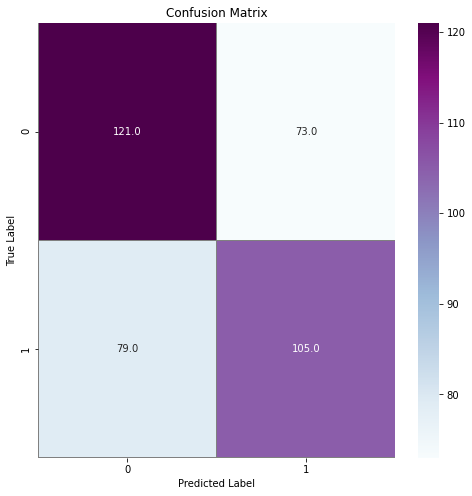

In [40]:
from sklearn.metrics import confusion_matrix
Y_pred = model.predict(X_test_mass)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test_mass,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

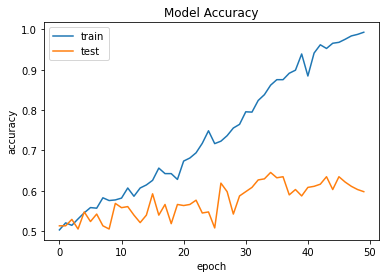

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

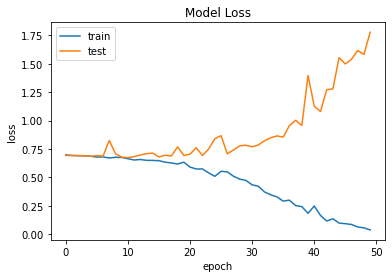

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **Preparamos el dataset de training de calc**

In [43]:
#Leemos los metadatos de training de masas
df_calc_train = pd.read_csv(f'{dataset_dir}/csv/calc_case_description_train_set.csv')

#Renombramos columnas con espacios
df_calc_train = df_calc_train.rename(columns={'image file path':'image_file_path'})
df_calc_train = df_calc_train.rename(columns={'cropped image file path':'cropped_image_file_path'})
df_calc_train = df_calc_train.rename(columns={'ROI mask file path':'ROI_mask_file_path'})

#Preparamos las columnas por las que buscaremos en dicom_info el path de la imagen
df_calc_train['image_file_path_studyInstanceUID'] = df_calc_train.image_file_path.str.split("/",expand=True,)[1]
df_calc_train['cropped_image_file_path_studyInstanceUID'] = df_calc_train.cropped_image_file_path.str.split("/",expand=True,)[1]

#Creamos dos "sub"datasets para luego buscar segun el tipo de imagen que nos interese
full_images=df[df.SeriesDescription == 'full mammogram images']
cropped_images=df[df.SeriesDescription == 'cropped images']

#Hacemos join de los datasets para crear el path de la imagen en el dataset de training
df_calc_train['full_image_path']=pd.merge(df_calc_train, full_images, left_on='image_file_path_studyInstanceUID', right_on='StudyInstanceUID')['image_path']
df_calc_train['cropped_image_path']=pd.merge(df_calc_train, cropped_images, left_on='cropped_image_file_path_studyInstanceUID', right_on='StudyInstanceUID')['image_path']

df_calc_train.head()


,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path,image_file_path_studyInstanceUID,cropped_image_file_path_studyInstanceUID,full_image_path,cropped_image_path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,1.3.6.1.4.1.9590.100.1.2.408909860712120272633...,1.3.6.1.4.1.9590.100.1.2.328778919012412769218...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,/home/fjcorrales/Master Ciencia de datos/TFM/d...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,1.3.6.1.4.1.9590.100.1.2.427517897311902339923...,1.3.6.1.4.1.9590.100.1.2.675123622103196361081...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,/home/fjcorrales/Master Ciencia de datos/TFM/d...
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,1.3.6.1.4.1.9590.100.1.2.201322325113694962619...,1.3.6.1.4.1.9590.100.1.2.241202057913673145232...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,/home/fjcorrales/Master Ciencia de datos/TFM/d...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,1.3.6.1.4.1.9590.100.1.2.370479499712916693322...,1.3.6.1.4.1.9590.100.1.2.314250272911170289203...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,/home/fjcorrales/Master Ciencia de datos/TFM/d...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,1.3.6.1.4.1.9590.100.1.2.162256682111885666305...,1.3.6.1.4.1.9590.100.1.2.336811694512764490002...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,/home/fjcorrales/Master Ciencia de datos/TFM/d...


/home/fjcorrales/Master Ciencia de datos/TFM/dataset/archive/jpeg/1.3.6.1.4.1.9590.100.1.2.295670217913556255928452747763741622478/1-213.jpg


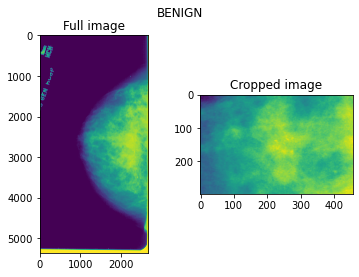

In [44]:
print(df_calc_train.loc[22, 'cropped_image_path'])
show_study(22,df_calc_train)

In [45]:
#Eliminamos nulos que hemos detectado
df_calc_train = df_calc_train.drop(df_calc_train.loc[df_calc_train['cropped_image_path'].isna()].index)

df_calc_train.loc[df_calc_train['cropped_image_path'].isna()].index

Int64Index([], dtype='int64')

Comprobamos las diferentes etiquetas de clasificacion

<AxesSubplot:>

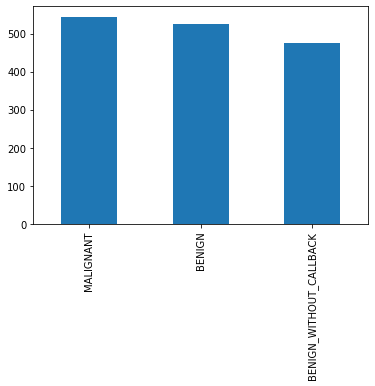

In [46]:
df_calc_train['pathology'].value_counts().plot(kind='bar')

Vamos a equipar la categoria BENIGN_WITHOUT_CALLBACK con BENIGN, para tener solo dos categorias.

<AxesSubplot:>

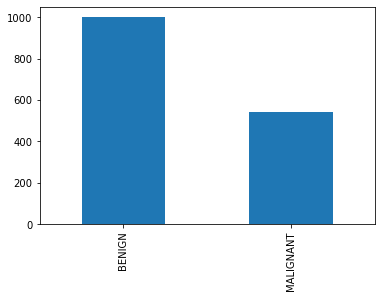

In [47]:
df_calc_train.loc[df_calc_train.pathology=='BENIGN_WITHOUT_CALLBACK','pathology']='BENIGN'
df_calc_train['pathology'].value_counts().plot(kind='bar')

Generamos los array de training redimensionando la imagen a los minimos encontrados

In [48]:
X_train_calc = []
y_train_calc = []


for i in range(len(df_calc_train)):
    img_cropped = cv2.imread(df_calc_train.loc[i, 'cropped_image_path'],cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(img_cropped, (filas, columnas), interpolation = cv2.INTER_LINEAR)
    X_train_calc.append(n_img_size)
    if df_calc_train.loc[i, 'pathology']=='BENIGN':
      y_train_calc.append(0)
    else:
      y_train_calc.append(1)
    
X_train_calc = np.array(X_train_calc)
y_train_calc = np.array(y_train_calc)

# **Preparamos el dataset de test de calc**

In [49]:
#Leemos los metadatos de training de masas
df_calc_test = pd.read_csv(f'{dataset_dir}/csv/calc_case_description_test_set.csv')

#Renombramos columnas con espacios
df_calc_test = df_calc_test.rename(columns={'image file path':'image_file_path'})
df_calc_test = df_calc_test.rename(columns={'cropped image file path':'cropped_image_file_path'})
df_calc_test = df_calc_test.rename(columns={'ROI mask file path':'ROI_mask_file_path'})

#Preparamos las columnas por las que buscaremos en dicom_info el path de la imagen
df_calc_test['image_file_path_studyInstanceUID'] = df_calc_test.image_file_path.str.split("/",expand=True,)[1]
df_calc_test['cropped_image_file_path_studyInstanceUID'] = df_calc_test.cropped_image_file_path.str.split("/",expand=True,)[1]

#Creamos dos "sub"datasets para luego buscar segun el tipo de imagen que nos interese
full_images=df[df.SeriesDescription == 'full mammogram images']
cropped_images=df[df.SeriesDescription == 'cropped images']

#Hacemos join de los datasets para crear el path de la imagen en el dataset de training
df_calc_test['full_image_path']=pd.merge(df_calc_test, full_images, left_on='image_file_path_studyInstanceUID', right_on='StudyInstanceUID')['image_path']
df_calc_test['cropped_image_path']=pd.merge(df_calc_test, cropped_images, left_on='cropped_image_file_path_studyInstanceUID', right_on='StudyInstanceUID')['image_path']

df_calc_test.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path,image_file_path_studyInstanceUID,cropped_image_file_path_studyInstanceUID,full_image_path,cropped_image_path
0,P_00038,2,LEFT,CC,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100...,Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...,1.3.6.1.4.1.9590.100.1.2.859354343102033567126...,1.3.6.1.4.1.9590.100.1.2.161465562211359959230...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,/home/fjcorrales/Master Ciencia de datos/TFM/d...
1,P_00038,2,LEFT,MLO,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....,Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....,1.3.6.1.4.1.9590.100.1.2.384159464510350889125...,1.3.6.1.4.1.9590.100.1.2.291121996131431385353...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,/home/fjcorrales/Master Ciencia de datos/TFM/d...
2,P_00038,2,RIGHT,CC,1,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....,Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....,1.3.6.1.4.1.9590.100.1.2.177706148911820252341...,1.3.6.1.4.1.9590.100.1.2.200764632211227648028...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,/home/fjcorrales/Master Ciencia de datos/TFM/d...
3,P_00038,2,RIGHT,CC,2,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....,Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....,1.3.6.1.4.1.9590.100.1.2.177706148911820252341...,1.3.6.1.4.1.9590.100.1.2.248538452013626298441...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,/home/fjcorrales/Master Ciencia de datos/TFM/d...
4,P_00038,2,RIGHT,MLO,1,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.1...,Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...,Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...,1.3.6.1.4.1.9590.100.1.2.328421320411501709324...,1.3.6.1.4.1.9590.100.1.2.348569460311013218440...,/home/fjcorrales/Master Ciencia de datos/TFM/d...,/home/fjcorrales/Master Ciencia de datos/TFM/d...


/home/fjcorrales/Master Ciencia de datos/TFM/dataset/archive/jpeg/1.3.6.1.4.1.9590.100.1.2.416175242512972515029128682820201897035/1-259.jpg


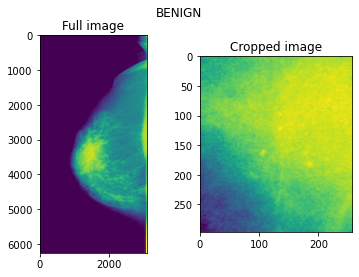

In [50]:
print(df_calc_test.loc[14, 'cropped_image_path'])
show_study(14,df_calc_test)

Generamos los array de test redimensionando la imagen a los minimos encontrados en el conjunto de training

In [51]:
X_test_calc = []
y_test_calc = []

for i in range(len(df_calc_test)):
    img_cropped = cv2.imread(df_calc_test.loc[i, 'cropped_image_path'],cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(img_cropped, (filas, columnas), interpolation = cv2.INTER_LINEAR)
    X_test_calc.append(n_img_size)

    if df_calc_test.loc[i, 'pathology']=='BENIGN':
      y_test_calc.append(0)
    else:
      y_test_calc.append(1)


X_test_calc = np.array(X_test_calc)
y_test_calc = np.array(y_test_calc)


y_train_calc = to_categorical(y_train_calc, 2)
y_test_calc = to_categorical(y_test_calc, 2)

print('X train shape : {}' .format(X_train_calc.shape))
print('y train shape : {}' .format(y_train_calc.shape))
print('X test shape : {}' .format(X_test_calc.shape))
print('y test shape : {}' .format(y_test_calc.shape))


X train shape : (1544, 68, 73, 3)
y train shape : (1544, 2)
X test shape : (326, 68, 73, 3)
y test shape : (326, 2)


# **Preparación y entrenamiento de una red CNN**
Hacemos una prueba con una red CNN sencilla para comprobar un modelo "tradicional" con el dataset de calc que acabamos de preparar

In [52]:
#Normalizamos los datos
X_train_calc= X_train_calc/255
X_test_calc = X_test_calc/255

In [53]:
model = tf.keras.Sequential([
tf.keras.layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (columnas,filas,  3)),
tf.keras.layers.MaxPooling2D(strides = 2),
tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
tf.keras.layers.MaxPooling2D((3, 3),strides = 2),
tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu'),
tf.keras.layers.MaxPooling2D((3, 3),strides =2),
tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu'),
tf.keras.layers.MaxPooling2D((3, 3),strides =2),
tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu'),
tf.keras.layers.MaxPooling2D((3, 3),strides =2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation = 'relu'),
tf.keras.layers.Dense(2, activation = 'softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 68, 73, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 34, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 36, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 17, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 17, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 7, 8, 128)       

In [54]:
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [55]:
#history = model.fit(X_train_mass, y_train_mass, validation_data = (X_test_mass, y_test_mass), epochs = 50 , batch_size = 20)

history = model.fit(X_train_calc, y_train_calc, epochs=50, validation_data=(X_test_calc, y_test_calc))




Epoch 1/50
49/49 [==============================] - 7s 126ms/step - loss: 0.6700 - accuracy: 0.6477 - val_loss: 0.7587 - val_accuracy: 0.3988
Epoch 2/50
49/49 [==============================] - 7s 145ms/step - loss: 0.6248 - accuracy: 0.6477 - val_loss: 0.9188 - val_accuracy: 0.3988
Epoch 3/50
49/49 [==============================] - 6s 126ms/step - loss: 0.6064 - accuracy: 0.6477 - val_loss: 0.9636 - val_accuracy: 0.3988
Epoch 4/50
49/49 [==============================] - 7s 134ms/step - loss: 0.5996 - accuracy: 0.6477 - val_loss: 0.9273 - val_accuracy: 0.3988
Epoch 5/50
49/49 [==============================] - 6s 128ms/step - loss: 0.5951 - accuracy: 0.6477 - val_loss: 0.8639 - val_accuracy: 0.3988
Epoch 6/50
49/49 [==============================] - 7s 144ms/step - loss: 0.5954 - accuracy: 0.6477 - val_loss: 0.9590 - val_accuracy: 0.3988
Epoch 7/50
49/49 [==============================] - 5s 110ms/step - loss: 0.5908 - accuracy: 0.6477 - val_loss: 0.8739 - val_accuracy: 0.3988
Epoch 

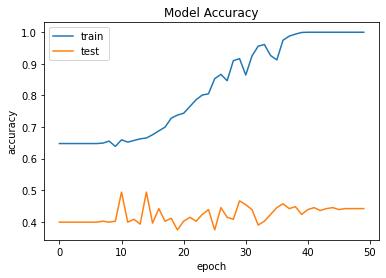

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

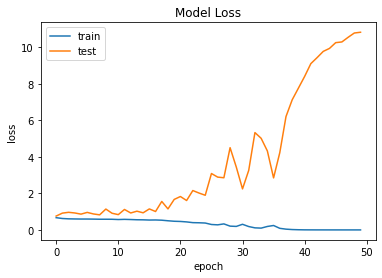

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Guardamos los datasets para usarlos en el siguiente notebook

In [58]:
df.to_csv(dataset_dir+'/dicom.csv')  
df_mass_train.to_csv(dataset_dir+'/mass_train.csv')  
df_mass_test.to_csv(dataset_dir+'/mass_test.csv')  
df_calc_train.to_csv(dataset_dir+'/calc_train.csv')  
df_calc_test.to_csv(dataset_dir+'/calc_test.csv')  

https://www.kaggle.com/code/suvoooo/understand-implement-vision-transformer-tf2-0
https://twitter.com/MLsummaries/status/1379789241614528515